# Emotion recognition. 

Note: important this script is written with an environment where GPU traning is possible
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
Anything above 2.10 is not supported on the GPU on Windows Native
python -m pip install "tensorflow<2.11"

DO Not try and run anything without the specicik environment as most modules will probably be out of date
and certain parameter, functions or modules with me depreciated.

In [1]:
#module install cell

In [4]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

#not cleaned
#some modules might not be used, ex no other optimzer than adam was used in the final project.

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, SeparableConv2D
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, InputLayer, GlobalMaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
# get data and investigate data

In [3]:
picture_size = 48
folder_path = "images/"

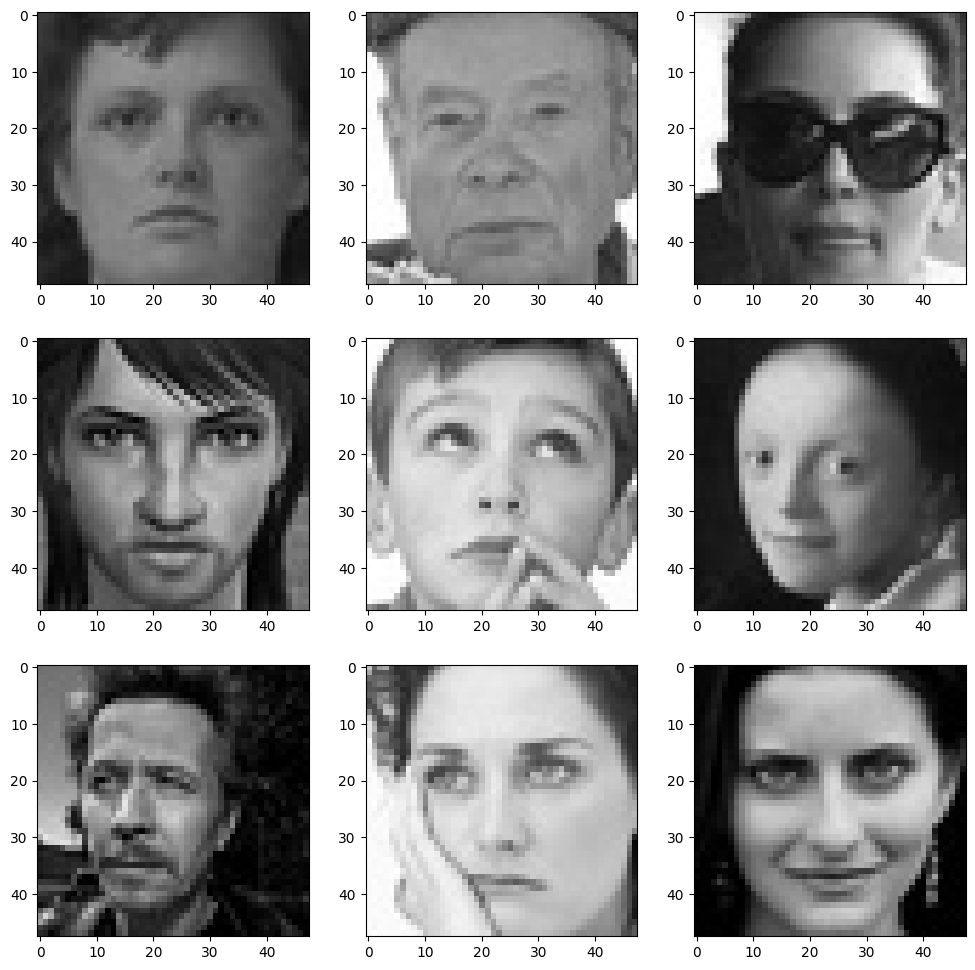

In [5]:
expressions = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']
expression = expressions[4]

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

Data augmentation

In [6]:
batch_size  = 128

#Altering data with different adjustment so that the model will learn to predict without
#perfect symetry

#important, must standardize pixels otherwise performance will be horrible
datagen_train  = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)



train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)



Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
#same as above but for xcenption as they only take 71x71 and above

batch_size  = 128
new_picture_size = 96

train_set_mod = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (new_picture_size,new_picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set_mod = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (new_picture_size,new_picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [32]:
#treated as global parameters as they will be used on all trained models

checkpoint = ModelCheckpoint(".modelcheckp.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=2,
                                        verbose=1,
                                        min_lr=0.00001,
                                        mode="auto")

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

# Build model

transfer learn xception model
https://www.tensorflow.org/api_docs/python/tf/keras/applications
cannot transferlearn as the weights the models are trained on are using a 3 channel but our pictures are grayscale
which means we can only have 1 channel. thus making the weights unusable

ref information about models: https://keras.io/api/applications/.
instead we can just take the architecture and retrained the weights for our purpose

In [40]:
#xception, a variant of googlenet which uses depthwise seperable convelution layers
#ref: https://arxiv.org/abs/1610.02357
#only takes atleast 71x71 picture inputs
from tensorflow.keras.applications import Xception
Xception_model = Xception(weights=None,
                  include_top=False,
                  input_shape=(new_picture_size,new_picture_size,1)
                  )

In [41]:
#we are essantially taking the xception arcitecture and training our data on it.
#for research purposes. 
#model must be trainable and not "frozen"
print(Xception_model.trainable)

True


We will always look into the architecture of the imported models and analyse

In [42]:
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   288         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_18 (Conv2D)             (None, 6, 6, 728)    186368      ['add_13[0][0]']                 
                                                                                                  
 block4_pool (MaxPooling2D)     (None, 6, 6, 728)    0           ['block4_sepconv2_bn[0][0]']     
          

 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv2_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv2[0][0]']        
 lization)

                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_21[0][0]']                 
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_22[0][0]']                 
 on)                                                                                              
          

In [43]:
model = Sequential()
model.add(Xception_model)

In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20860904  
                                                                 
Total params: 20,860,904
Trainable params: 20,806,376
Non-trainable params: 54,528
_________________________________________________________________


In [45]:
#this last layer structure will be done on all experiments
#build last layers
classes = len(expressions)
#flatten
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

In [47]:
#decay might be depreciated in future versions
opt = Adam(lr = 0.0001, decay=1e-5)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20860904  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_7 (Dense)             (None, 7)                 129031    
                                                                 
Total params: 20,989,935
Trainable params: 20,935,407
Non-trainable params: 54,528
_________________________________________________________________


# Fitting model

In [48]:
#.fit is used when the entire training dataset can fit into the memory and no data augmentation is applied.
#.fit_generator is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.
#.fit_generated will be deprecated so use .fit
#training on modified train/test to satisfy input
history_xcen = model.fit(x=train_set_mod,
                         steps_per_epoch=train_set_mod.n//(batch_size),
                         epochs=epochs,
                         validation_data = test_set_mod,
                         validation_steps = test_set_mod.n//(batch_size),
                         callbacks=callbacks_list
                         )

Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.7150 - accuracy: 0.3186
Epoch 1: val_accuracy improved from -inf to 0.16179, saving model to .modelcheckp.h5
225/225 [==============================] - 60s 250ms/step - loss: 1.7150 - accuracy: 0.3186 - val_loss: 1.9348 - val_accuracy: 0.1618 - lr: 1.0000e-04
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.5785 - accuracy: 0.3851
Epoch 2: val_accuracy did not improve from 0.16179
225/225 [==============================] - 90s 402ms/step - loss: 1.5785 - accuracy: 0.3851 - val_loss: 1.9030 - val_accuracy: 0.1618 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.4910 - accuracy: 0.4258
Epoch 3: val_accuracy improved from 0.16179 to 0.26023, saving model to .modelcheckp.h5
225/225 [==============================] - 59s 264ms/step - loss: 1.4910 - accuracy: 0.4258 - val_loss: 1.7193 - val_accuracy: 0.2602 - lr: 1.0000e-04
Epoch 4/48
225/225 [===============

In [49]:
#save model
model.save("Xception_model96x.h5")

In [52]:
#ref: https://arxiv.org/abs/2104.00298
from tensorflow.keras.applications import EfficientNetV2S

EfficientNetV2S_model = EfficientNetV2S(weights=None,
                  include_top=False,
                  input_shape=(picture_size,picture_size,1)
                  )

In [53]:
print(EfficientNetV2S_model.trainable)

True


In [54]:
EfficientNetV2S_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 1)    0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 24)   216         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 24, 24, 24)   96          ['stem_conv[0][0]']              
                                                                                   

 block2c_project_bn (BatchNorma  (None, 12, 12, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_drop (Dropout)         (None, 12, 12, 48)   0           ['block2c_project_bn[0][0]']     
                                                                                                  
 block2c_add (Add)              (None, 12, 12, 48)   0           ['block2c_drop[0][0]',           
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 12, 12, 192)  82944       ['block2c_add[0][0]']            
                                                                                                  
 block2d_e

                                                                                                  
 block3d_expand_activation (Act  (None, 6, 6, 256)   0           ['block3d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3d_project_conv (Conv2D)  (None, 6, 6, 64)     16384       ['block3d_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3d_project_bn (BatchNorma  (None, 6, 6, 64)    256         ['block3d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3d_d

 block4b_drop (Dropout)         (None, 3, 3, 128)    0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 3, 3, 128)    0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 3, 3, 512)    65536       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 3, 3, 512)   2048        ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_e

 block4e_expand_conv (Conv2D)   (None, 3, 3, 512)    65536       ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 3, 3, 512)   2048        ['block4e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4e_expand_activation (Act  (None, 3, 3, 512)   0           ['block4e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4e_dwconv2 (DepthwiseConv  (None, 3, 3, 512)   4608        ['block4e_expand_activation[0][0]
 2D)                                                             ']                               
          

 block5a_expand_activation (Act  (None, 3, 3, 768)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 3, 3, 768)   6912        ['block5a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 3, 3, 768)   3072        ['block5a_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5a_activation (Activation  (None, 3, 3, 768)   0           ['block5a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 960)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5c_se_reduce[0][0]']      
          

 block5e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 3, 3, 960)    0           ['block5e_activation[0][0]',     
                                                                  'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 3, 3, 160)    153600      ['block5e_se_excite[0][0]']      
          

                                                                                                  
 block5g_se_excite (Multiply)   (None, 3, 3, 960)    0           ['block5g_activation[0][0]',     
                                                                  'block5g_se_expand[0][0]']      
                                                                                                  
 block5g_project_conv (Conv2D)  (None, 3, 3, 160)    153600      ['block5g_se_excite[0][0]']      
                                                                                                  
 block5g_project_bn (BatchNorma  (None, 3, 3, 160)   640         ['block5g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5g_drop (Dropout)         (None, 3, 3, 160)    0           ['block5g_project_bn[0][0]']     
          

                                                                                                  
 block5i_project_bn (BatchNorma  (None, 3, 3, 160)   640         ['block5i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5i_drop (Dropout)         (None, 3, 3, 160)    0           ['block5i_project_bn[0][0]']     
                                                                                                  
 block5i_add (Add)              (None, 3, 3, 160)    0           ['block5i_drop[0][0]',           
                                                                  'block5h_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 3, 3, 960)    153600      ['block5i_add[0][0]']            
          

                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 2, 2, 1536)  6144        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 2, 2, 1536)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv2 (DepthwiseConv  (None, 2, 2, 1536)  13824       ['block6c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6c_b

 ivation)                                                                                         
                                                                                                  
 block6e_dwconv2 (DepthwiseConv  (None, 2, 2, 1536)  13824       ['block6e_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 2, 2, 1536)  6144        ['block6e_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 2, 2, 1536)  0           ['block6e_bn[0][0]']             
 )                                                                                                
          

 block6g_bn (BatchNormalization  (None, 2, 2, 1536)  6144        ['block6g_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6g_activation (Activation  (None, 2, 2, 1536)  0           ['block6g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 1536)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6g_se_squeeze[0][0]']     
          

                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 1536)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6i_se_squeeze[0][0]']     
                                                                                                  
 block6i_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6i_se_reshape[0][0]']     
                                                                                                  
 block6i_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6i_se_reduce[0][0]']      
                                                                                                  
 block6i_s

                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6k_se_reduce[0][0]']      
                                                                                                  
 block6k_se_excite (Multiply)   (None, 2, 2, 1536)   0           ['block6k_activation[0][0]',     
                                                                  'block6k_se_expand[0][0]']      
                                                                                                  
 block6k_project_conv (Conv2D)  (None, 2, 2, 256)    393216      ['block6k_se_excite[0][0]']      
                                                                                                  
 block6k_p

 block6m_se_excite (Multiply)   (None, 2, 2, 1536)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 2, 2, 256)    393216      ['block6m_se_excite[0][0]']      
                                                                                                  
 block6m_project_bn (BatchNorma  (None, 2, 2, 256)   1024        ['block6m_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6m_drop (Dropout)         (None, 2, 2, 256)    0           ['block6m_project_bn[0][0]']     
                                                                                                  
 block6m_a

 block6o_project_bn (BatchNorma  (None, 2, 2, 256)   1024        ['block6o_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6o_drop (Dropout)         (None, 2, 2, 256)    0           ['block6o_project_bn[0][0]']     
                                                                                                  
 block6o_add (Add)              (None, 2, 2, 256)    0           ['block6o_drop[0][0]',           
                                                                  'block6n_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 2, 2, 1280)   327680      ['block6o_add[0][0]']            
                                                                                                  
 top_bn (B

In [59]:
model = Sequential()
model.add(EfficientNetV2S_model)

#flatten
model.add(Flatten())

model.add(Dense(classes, activation='softmax'))

opt = Adam(lr = 0.0001, decay=1e-5)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20330928  
 l)                                                              
                                                                 
 flatten_6 (Flatten)         (None, 5120)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                 35847     
                                                                 
Total params: 20,366,775
Trainable params: 20,212,903
Non-trainable params: 153,872
_________________________________________________________________


In [60]:
#use normal 48x image
history_v2s = model.fit(x=train_set,
                        steps_per_epoch=train_set.n//train_set.batch_size,
                        epochs=epochs,
                        validation_data = test_set,
                        validation_steps = test_set.n//test_set.batch_size,
                        callbacks=callbacks_list
                        )

Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.9635 - accuracy: 0.2328
Epoch 1: val_accuracy did not improve from 0.64673
225/225 [==============================] - 61s 186ms/step - loss: 1.9635 - accuracy: 0.2328 - val_loss: 1.8114 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.9122 - accuracy: 0.2379
Epoch 2: val_accuracy did not improve from 0.64673
225/225 [==============================] - 39s 173ms/step - loss: 1.9122 - accuracy: 0.2379 - val_loss: 1.8107 - val_accuracy: 0.2582 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.8915 - accuracy: 0.2395
Epoch 3: val_accuracy did not improve from 0.64673
225/225 [==============================] - 38s 168ms/step - loss: 1.8915 - accuracy: 0.2395 - val_loss: 1.8086 - val_accuracy: 0.2584 - lr: 1.0000e-04
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.8730 - accuracy: 0.2407
Epoch 4: v

In [61]:
#save model
model.save("EfficientNetV2S_model.h5")

In [62]:
print(max(history_xcen.history['val_accuracy']))
print(max(history_v2s.history['val_accuracy']))

0.6467329263687134
0.373153418302536


In [70]:
#Creating my own model, with some inspiration from xception achitecture and akshits model
#The batch normalization can be applied before and after the activation function.
#However, research shows its best when applied before the activation function.
#apply depthwise conv https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution
#Per Hands-On_Machine_Learning_with_Scikit-Learn-Keras-and-TensorFlow-2nd-Edition-Aurelien-Geron
#Selu will perform the best as long as some conditions are met.
#input features should be standardizeds which they are.
#and kernel_initializer="lecun_normal" should be used in hidden layers
#selu gave poor results, trying relu, faster training.

classes = len(expressions)
actv_func = "relu"
dropout = 0.2

model = Sequential()

#1st CNN layer
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (picture_size,picture_size,1)))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(Dropout(dropout))

#2nd CNN layer
model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

#1st sepconv layer
model.add(SeparableConv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(Dropout(dropout))

#2nd sepconv layer
model.add(SeparableConv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

#flatten
model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(128,kernel_initializer="lecun_normal"))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(Dropout(dropout))

# Fully connected layer 2nd layer
model.add(Dense(64,kernel_initializer="lecun_normal"))
model.add(BatchNormalization())
model.add(Activation(actv_func))
model.add(Dropout(dropout))

model.add(Dense(classes))
model.add(Activation("softmax"))



opt = Adam(lr = 0.0001, decay=1e-5)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_44 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 dropout_32 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_45 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                    

D:\program\anaconda\envs\tensorflowgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [71]:
history_mymodel = model.fit(x=train_set,
                            steps_per_epoch=train_set.n//train_set.batch_size,
                            epochs=epochs,
                            validation_data = test_set,
                            validation_steps = test_set.n//test_set.batch_size,
                            callbacks=callbacks_list
                            ) 

Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.9870 - accuracy: 0.2548
Epoch 1: val_accuracy did not improve from 0.64673
225/225 [==============================] - 34s 143ms/step - loss: 1.9870 - accuracy: 0.2548 - val_loss: 2.0593 - val_accuracy: 0.1724 - lr: 1.0000e-04
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.2840
Epoch 2: val_accuracy did not improve from 0.64673
225/225 [==============================] - 19s 86ms/step - loss: 1.8435 - accuracy: 0.2840 - val_loss: 1.9462 - val_accuracy: 0.2313 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.7854 - accuracy: 0.3065
Epoch 3: val_accuracy did not improve from 0.64673
225/225 [==============================] - 19s 86ms/step - loss: 1.7854 - accuracy: 0.3065 - val_loss: 1.7863 - val_accuracy: 0.2909 - lr: 1.0000e-04
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.7322 - accuracy: 0.3191
Epoch 4: val

225/225 [==============================] - 19s 85ms/step - loss: 1.2861 - accuracy: 0.5126 - val_loss: 1.1612 - val_accuracy: 0.5618 - lr: 1.0000e-04
Epoch 29/48
225/225 [==============================] - ETA: 0s - loss: 1.2703 - accuracy: 0.5155
Epoch 29: val_accuracy did not improve from 0.64673
225/225 [==============================] - 20s 87ms/step - loss: 1.2703 - accuracy: 0.5155 - val_loss: 1.1174 - val_accuracy: 0.5751 - lr: 1.0000e-04
Epoch 30/48
225/225 [==============================] - ETA: 0s - loss: 1.2653 - accuracy: 0.5196
Epoch 30: val_accuracy did not improve from 0.64673
225/225 [==============================] - 19s 85ms/step - loss: 1.2653 - accuracy: 0.5196 - val_loss: 1.0938 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 31/48
225/225 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.5224
Epoch 31: val_accuracy did not improve from 0.64673
225/225 [==============================] - 20s 90ms/step - loss: 1.2610 - accuracy: 0.5224 - val_loss: 

In [72]:
model.save("mymodel.h5")

# Compare training history training acc/loss and val acc/loss

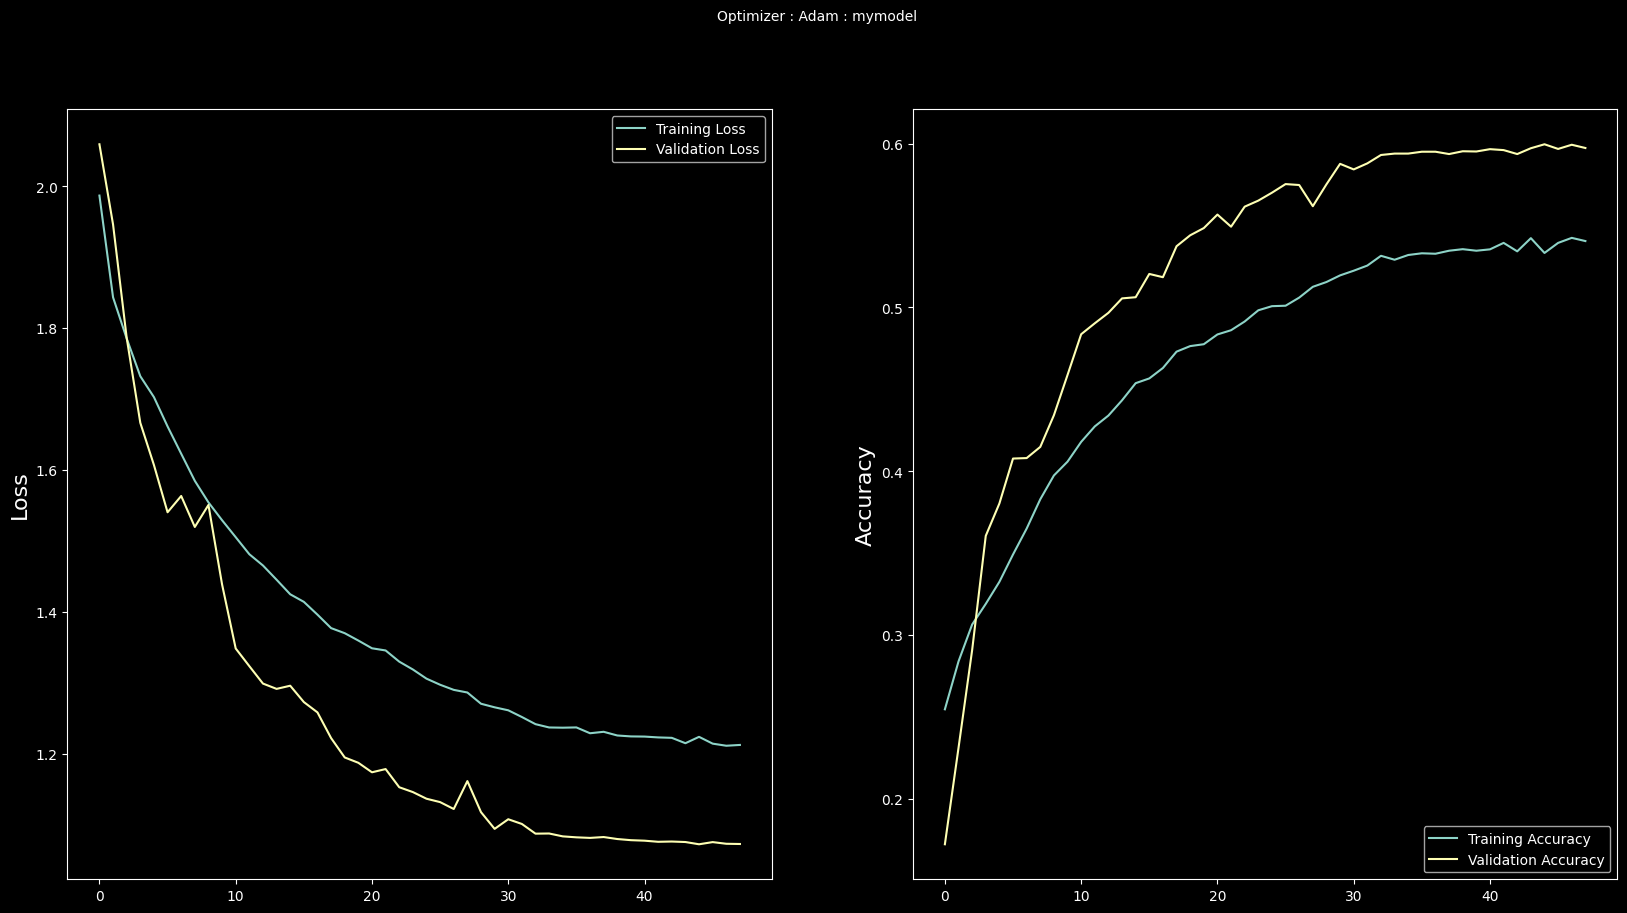

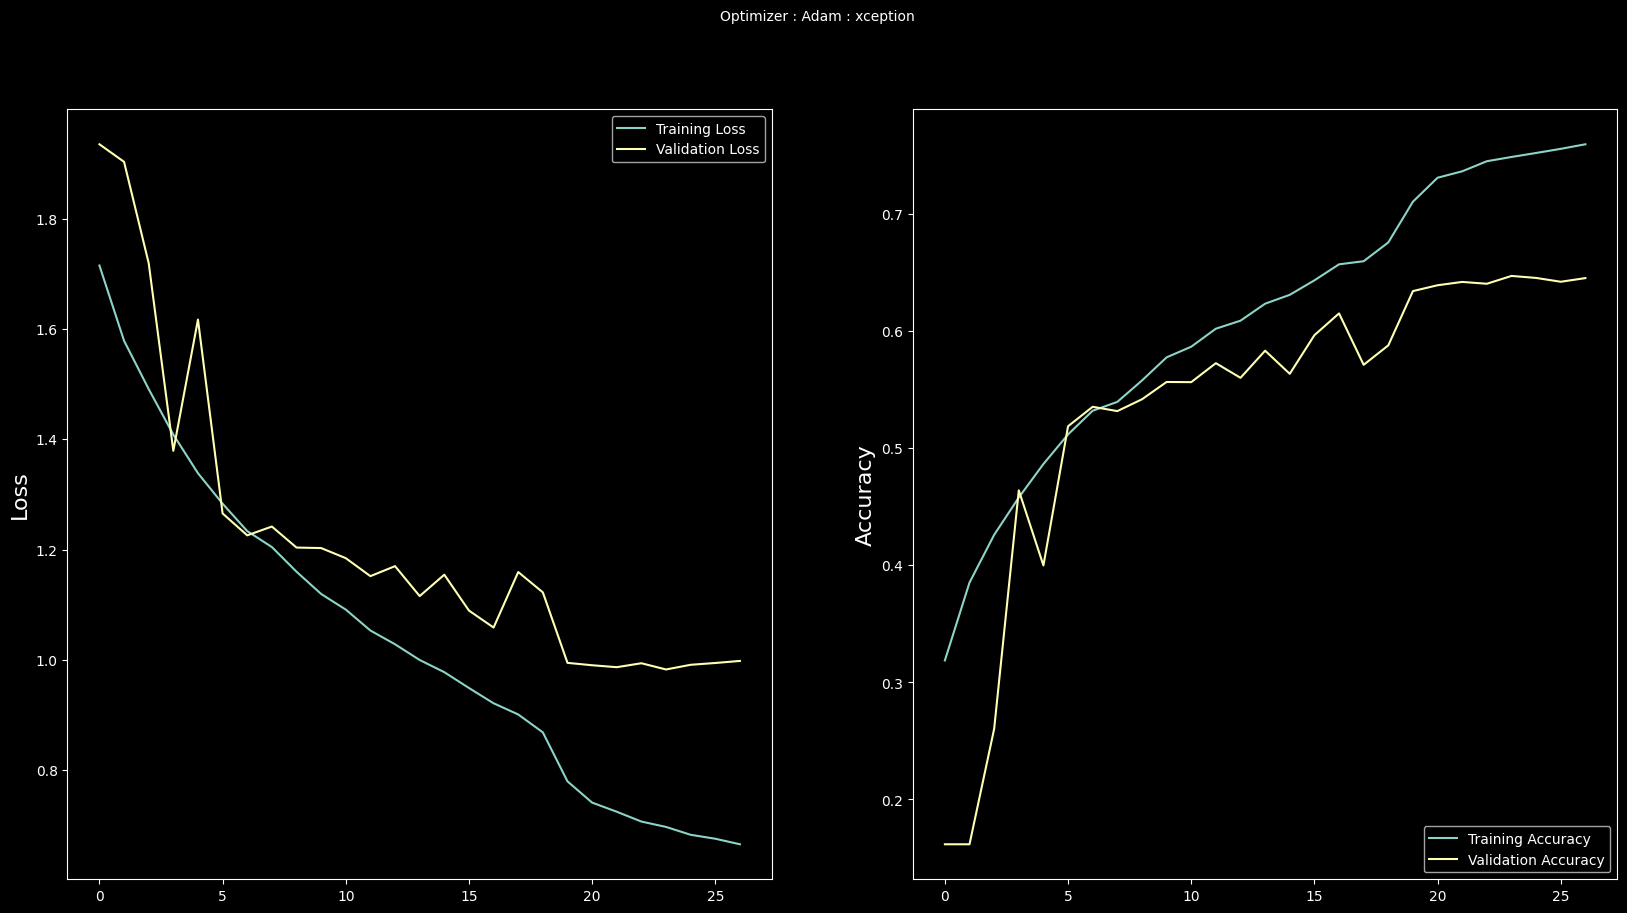

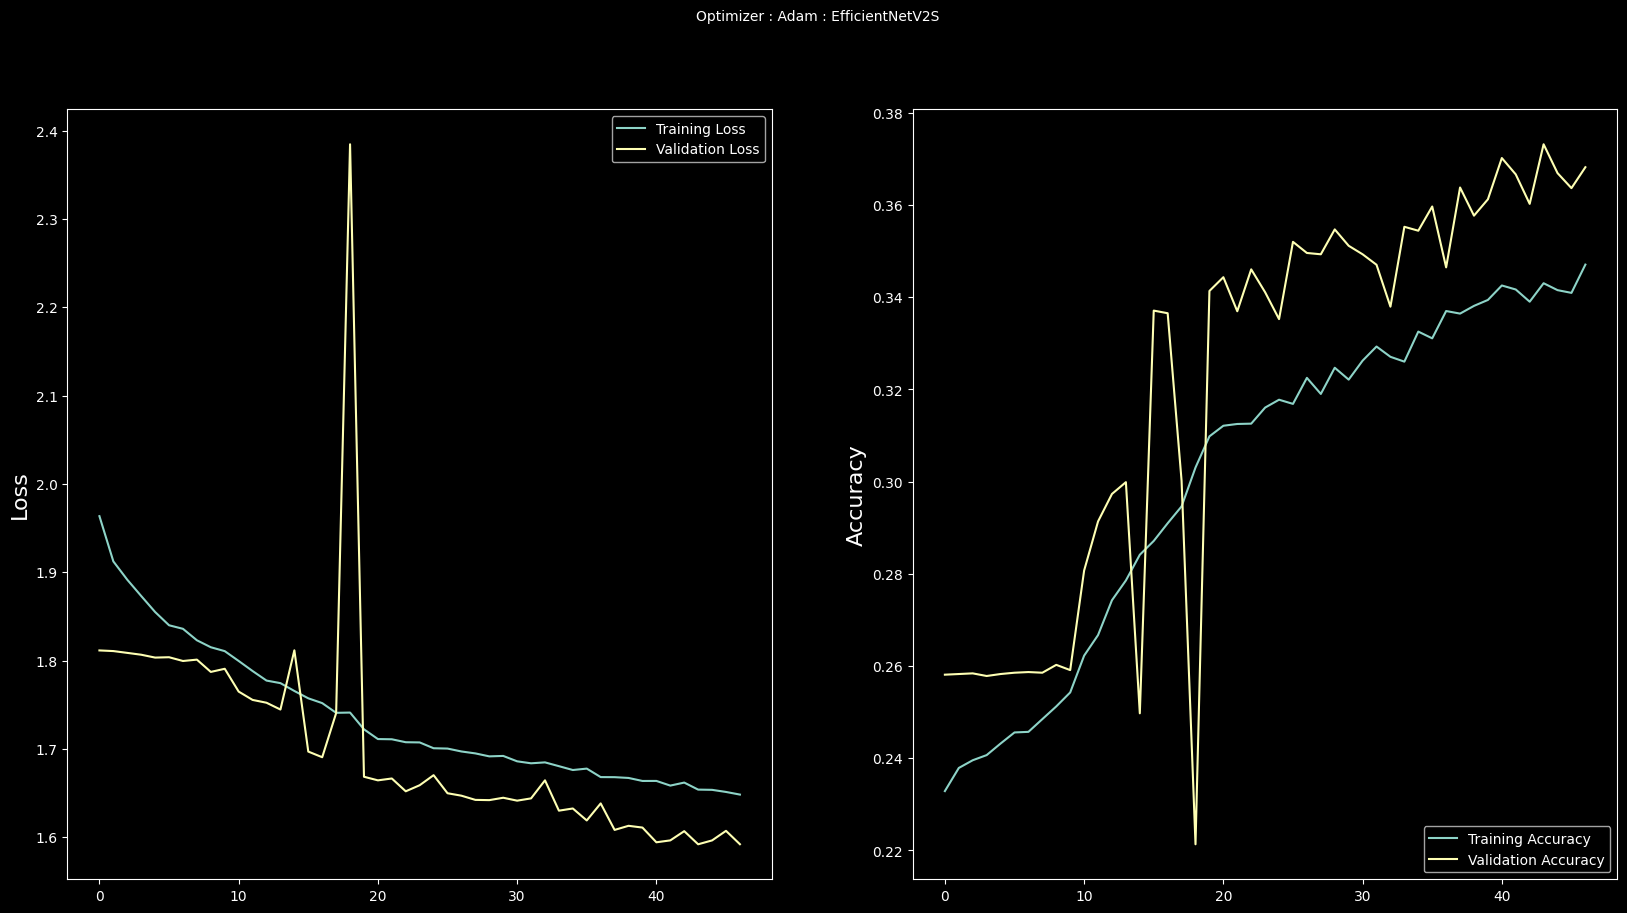

In [73]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam : mymodel', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_mymodel.history['loss'], label='Training Loss')
plt.plot(history_mymodel.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_mymodel.history['accuracy'], label='Training Accuracy')
plt.plot(history_mymodel.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam : xception', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_xcen.history['loss'], label='Training Loss')
plt.plot(history_xcen.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_xcen.history['accuracy'], label='Training Accuracy')
plt.plot(history_xcen.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam : EfficientNetV2S', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_v2s.history['loss'], label='Training Loss')
plt.plot(history_v2s.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_v2s.history['accuracy'], label='Training Accuracy')
plt.plot(history_v2s.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [2]:
from tensorflow.keras.models import load_model
effnetvs2_model = load_model("EfficientNetV2S_model.h5")
xception_model  = load_model("Xception_model96x.h5")
my_model        = load_model("mymodel.h5")

# Evaluating models on test set. 
Final model will be tested on live feed

In [9]:
pred_effnetvs2_model = effnetvs2_model.predict(test_set)
pred_xception_model  = xception_model.predict(test_set_mod)
pred_my_model        = my_model.predict(test_set)

56/56 [==============================] - 2s 39ms/step


In [36]:
print(np.argmax(pred_effnetvs2_model[1]))
pred_effnetvs2_model[1]

6


array([0.17666698, 0.01528751, 0.1983463 , 0.06001113, 0.14689742,
       0.18948513, 0.21330556], dtype=float32)

In [12]:
test_set.labels

array([0, 0, 0, ..., 6, 6, 6])

In [18]:
#counting true labels
k = np.array([0,0,0,0,0,0,0])
for i in range(len(test_set.labels)):
    k[test_set.labels[i]] = k[test_set.labels[i]]+1
print(k)

[ 960  111 1018 1825 1216 1139  797]


By dividing the predicted elements over the true labels we can se if we over or under predicted values

In [35]:
#counting effnetvs2_model predictions

j = np.array([0,0,0,0,0,0,0])
for i in range(len(pred_effnetvs2_model)):
    j[np.argmax(pred_effnetvs2_model[i])] = j[np.argmax(pred_effnetvs2_model[i])]+1
print(j)
print(j/k)
print(sum(j/k)/7)

[ 139    0  141 2174 2014 1153 1445]
[0.14479167 0.         0.13850688 1.19123288 1.65625    1.01229148
 1.81304893]
0.8508745481236003


In [34]:
#counting xception_model predictions

j = np.array([0,0,0,0,0,0,0])
for i in range(len(pred_xception_model)):
    j[np.argmax(pred_xception_model[i])] = j[np.argmax(pred_xception_model[i])]+1
print(j)
print(j/k)
print(sum(j/k)/7)

[ 966   82  743 1779 1447 1240  809]
[1.00625    0.73873874 0.72986248 0.97479452 1.18996711 1.08867428
 1.01505646]
0.9633347967719715


In [33]:
#counting my_model predictions

j = np.array([0,0,0,0,0,0,0])
for i in range(len(pred_my_model)):
    j[np.argmax(pred_my_model[i])] = j[np.argmax(pred_my_model[i])]+1
print(j)
print(j/k)
print(sum(j/k)/7)

[ 691   66  638 1869 1576 1382  844]
[0.71979167 0.59459459 0.62671906 1.02410959 1.29605263 1.21334504
 1.05897114]
0.9333691028779694


# Notes

The xception model seem to perform the best, having the highest val acc and predict acc
Note:
when using live detection the xception model is able to detect all emotions but struggles a lot between distinguishing
emotions like fear/sad/disgust. neutral seems to be the strongest next to happy and angry.
The "mymodel" seems to perform better in detecting different emotions without as much exagurated effort.
This might mean that the xceptionmodel achieves som what of and overfit when training.
the xception model is also trained on 96x96 images which might perform with the camera.
Note that the val accuracy surpases the train accuracy when training the "mymodel".
Which implies that the model performs well on new data.

In [1]:
####